In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from shapely.geometry import point, Polygon
import rioxarray
from pyproj import CRS
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import requests
from osgeo import gdal
from osgeo import ogr
import fiona
%matplotlib inline
from shapely.geometry import Polygon
import shapefile

from rasterio.mask import mask
import plotly.graph_objects as go

In [2]:
address = 'Velodreef 2, 2910 Essen'

In [3]:
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

In [4]:
polygon = get_coordinates(address)
x_polygon = [i[0] for i in polygon]
y_polygon = [i[1] for i in polygon]
# calculate bounds of a rectangle that contains the polygon
left = min(x_polygon)
right = max(x_polygon)
top = max(y_polygon)
bottom = min(y_polygon)
# print(f"left = {left}, right = {right}, top = {top}, bottom = {bottom}")

In [5]:
# convert polygon to a Shapely format
polygon_shapely = Polygon(polygon)
polygon_shapely.buffer(2.0)

# save a polygon to a .shp file
w = shapefile.Writer('shapefiles/polygon')
w.field('name', 'C')

w.poly([polygon])
w.record('polygon1')

w.close()

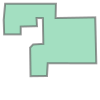

In [25]:
polygon_shapely

In [6]:
polygon_path = 'C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp'


In [7]:
df = pd.read_csv('DTM_bounds.csv')

In [8]:
for index, row in df.iterrows():
    if left >= row.left and right <= row.right and top <= row.top and bottom >= row.bottom:
        right_dtm_url = row.url_dtm
        right_dsm_url = row.url_dsm
print(right_dsm_url)       
print(right_dtm_url)

zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k01.zip!/GeoTIFF/DHMVIIDSMRAS1m_k01.tif
zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k01.zip!/GeoTIFF/DHMVIIDTMRAS1m_k01.tif


In [9]:
def clip_geotiff(file):
    with fiona.open("C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(file) as src:
        return rasterio.mask.mask(src, shapes, crop=True)


In [10]:
dsm_clip = clip_geotiff(right_dsm_url)

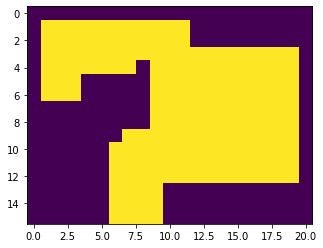

In [34]:
plt.imshow(dsm_clip[0][0])

In [11]:
dtm_clip = clip_geotiff(right_dtm_url)

In [37]:
chm = dsm_clip[0][0] - dtm_clip[0][0]

In [39]:
chm.shape

(16, 21)

In [15]:
type(chm)

numpy.ndarray

In [16]:
len(chm)

16

In [17]:
type(np.arange(chm.shape[1]))

numpy.ndarray

In [18]:
type(np.arange(chm.shape[0]))

numpy.ndarray

In [64]:
z = chm
x, y = np.arange(chm.shape[1]),np.arange(chm.shape[0])
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
#fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50)])
fig.update_layout(title= f'3D House Model: {address}', autosize=False)
fig.show()

In [59]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [62]:
fig.write_image("images/fig1.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
